# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Gabriel Tornare, Kilian Meier, Jérôme Savary  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, '..\\..\\data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
data_path = os.path.join(data_base_path, data_folder)

In [39]:
import skimage.io
import matplotlib.pyplot as plt

#method 1 :
import imageio #to load png pictures
from skimage import img_as_ubyte
from skimage import filters
from skimage.color import rgb2gray
from skimage.color import rgba2rgb
from skimage.filters import rank
from skimage.morphology import disk
from skimage.draw import rectangle
from skimage.measure import label
import numpy as np
from skimage.segmentation import watershed

#method 2 :
# from skimage.util import img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

In [6]:
#PROBABLY NOT USEFUL
#from skimage.draw import circle
#from skimage.morphology import erosion
#from skimage.morphology import closing
#from skimage.morphology import opening

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [5]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


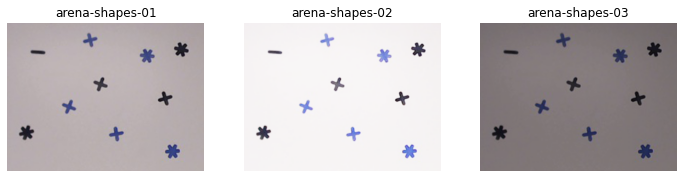

In [6]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
#### Algorithm 
The process can be described by the following steps:
1. Convert image to gray scale
2. Denoise the image using a median filter
3. Find background by thresholding and use remaining pixels as markers
4. Perform watersheding on sobel edges of original image
5. Computing mean color and size of each object
6. Compute separation threshold
7. Classify objects and compute number of object and area per class
8. Display the results

#### Discussion
This approach leads to good results : all the objects are correctly classified and well delimited. However it relies on several assumption. First, the background threshold definition relies on the fact that the background is dominant in the image (taking the mean of the image), this is ok while the objects are sparse in the image and the background is homogeneous. This could be solved by using other background removal approach, here an active contour might be an interesting solution. Second, the classification between objects relies on the fact that there are around the same number of objects in each class (mean of the mean color), this can be solved by using other classification approaches such as k-means for example.
This approach uses only grayscale images, but one could maybe benefit from the color information to create a more robust algorithm, maybe changing color space and using one of those dimensions could be interesting. 
Finally, one could question the use of the watersheding since the markers computed are already pretty good object segmentations, but watersheding adds probably some robustness and could lead to better edges depending on the contrast of the original image.

###  ================== JUST LABELS A PICTURE ================

(316, 1736, 4)


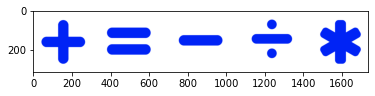

In [45]:
im = imageio.imread('../../data/original_operators.png')
print(im.shape)
plt.imshow(im)

(316, 1736)


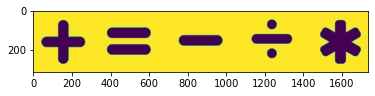

In [46]:
greyim = rgb2gray(rgba2rgb(im))
print(greyim.shape)
plt.imshow(greyim)

In [50]:
width = greyim.shape[1]//5

In [52]:
width

347

In [56]:
symbols = [ None for i in np.arange(5)]
for i in np.arange(5):
  symbols[i] = greyim[:,width*i:width*(i+1)]

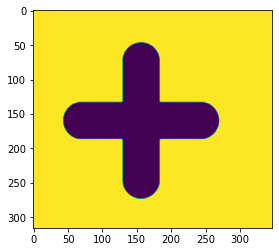

In [64]:
plt.imshow(symbols[0])

In [19]:
for im in images: #for each image
    # convert to grayscale
    im_gray = rgb2gray(im)
    # denoise image
    
    denoised = rank.median(img_as_ubyte(im_gray), disk(1))

    # define markers for wateshed
    # one small rectagle to define background
    # and markers where there is no background
    # background is defined as an interval around the mean color of the image
    markers = np.zeros_like(im_gray)
    thresh = np.average(im_gray)
    interval = 0.1
    markers[im_gray<thresh-interval] = 1
    markers[im_gray>thresh+interval] = 1
    rr, cc = rectangle((0,0), extent=(20,20), shape=markers.shape)
    markers[rr,cc] = 1    
    markers = label(markers)

    # sobel edges
    edge_sobel = filters.sobel(denoised)

    # perform the watershed
    labels = watershed(edge_sobel, markers) 
    
# perform clustering 
nb_obj = np.max(labels)-1
print(nb_obj)
    

10


Nbr of black objects 5 total area 5507, nbr of blue objects 5 total area 5616


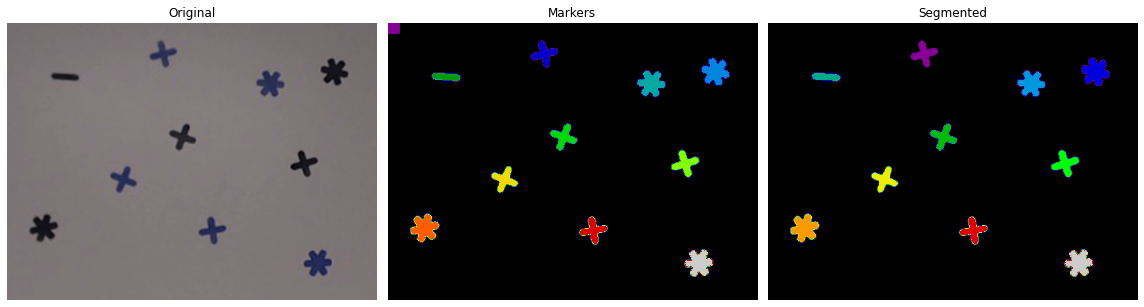

In [17]:
    # display results
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8),
                             sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(im)
    ax[0].set_title("Original")

    ax[1].imshow(markers, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[1].set_title("Markers")

    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[2].set_title("Segmented")
    
    print("Nbr of black objects {} total area {}, nbr of blue objects {} total area {}".format(nbrBlack,areaBlack,nbrBlue,areaBlue))

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

### =====================  What was done for the lab =========================== :

Nbr of black objects 5 total area 5708, nbr of blue objects 5 total area 5829


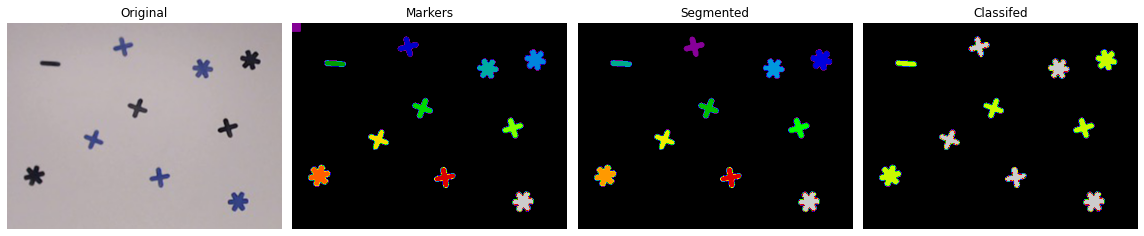

Nbr of black objects 5 total area 5133, nbr of blue objects 5 total area 5156


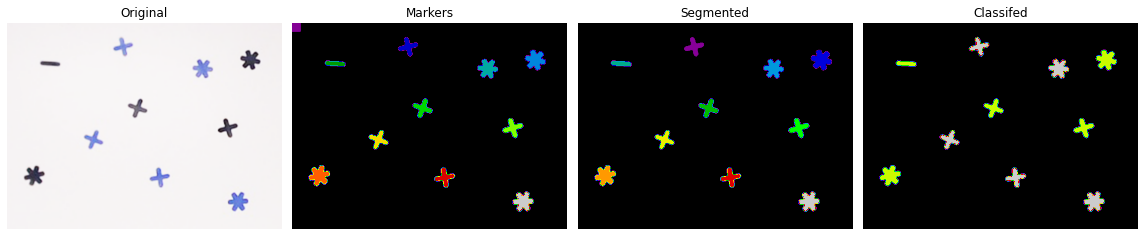

Nbr of black objects 5 total area 5507, nbr of blue objects 5 total area 5616


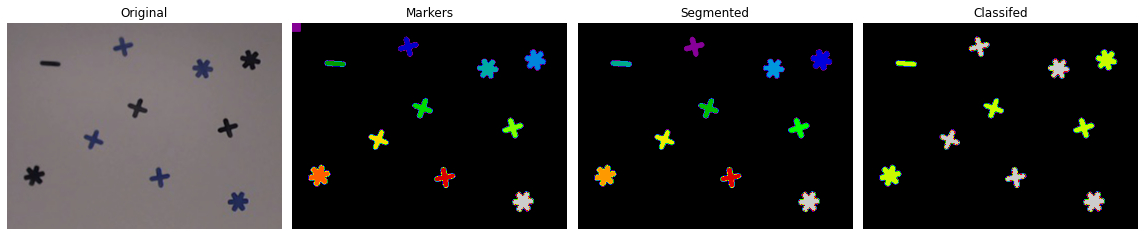

In [7]:

for im in images :
    # convert to grayscale
    im_gray = rgb2gray(im)

    # denoise image
    denoised = rank.median(img_as_ubyte(im_gray), disk(1))

    # define markers for wateshed
    # one small rectagle to define background
    # and markers where there is no background
    # background is defined as an interval around the mean color of the image
    markers = np.zeros_like(im_gray)
    thresh = np.average(im_gray)
    interval = 0.1
    markers[im_gray<thresh-interval] = 1
    markers[im_gray>thresh+interval] = 1
    rr, cc = rectangle((0,0), extent=(20,20), shape=markers.shape)
    markers[rr,cc] = 1    
    markers = label(markers)

    
    # sobel edges
    edge_sobel = filters.sobel(denoised)

    # perform the watershed
    labels = watershed(edge_sobel, markers)    
    
    # computing mean color and size of each object
    objMean = {}
    objSize = {}
    for i in range(2,np.max(labels)+1) :
        objMean[i] = np.average(im_gray[labels==i])
        objSize[i] = np.sum(labels==i)
    
    # calculating a speration threshold to classify the mean color of the object
    # the threshold is defined as the average of the all mean colors
    sep = np.average(list(objMean.values()))
    
    # classifying objects by comparing them to the treshold
    # creating an image with the classified objects
    # counting the object in each class
    # adding up the total area of each color 
    nbrBlue = 0
    nbrBlack = 0
    areaBlue = 0
    areaBlack = 0
    res = np.zeros_like(im_gray)
    
    for obj in objMean :
        if objMean[obj] > sep :
            nbrBlue = nbrBlue + 1
            areaBlue = areaBlue + objSize[obj]
            res[labels==obj] = 3
        else :
            nbrBlack = nbrBlack + 1
            areaBlack = areaBlack + objSize[obj]
            res[labels==obj] = 2
    

    # display results
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 8),
                             sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(im)
    ax[0].set_title("Original")

    ax[1].imshow(markers, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[1].set_title("Markers")

    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[2].set_title("Segmented")
    
    ax[3].imshow(res, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[3].set_title("Classifed")
    
    print("Nbr of black objects {} total area {}, nbr of blue objects {} total area {}".format(nbrBlack,areaBlack,nbrBlue,areaBlue))

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

### 2.2 (bis) Number of shapes of each color 
#### Algorithm 
Note : The beginning is the same as the previous algorithm. What changes is once we have our objects, we cluster them using Kmeans.
The process can be described by the following steps:
1. Convert image to gray scale
2. Denoise the image using a median filter
3. Find background by thresholding and use remaining pixels as markers
4. Perform watersheding on sobel edges of original image (to get the different objects)
5. Computing mean color of each object
6. Clustering the objects using Kmeans. 
7. Display the results

#### Discussion
This approach leads to good results : all the objects are correctly classified and well delimited. However it relies on several assumptions. For the first part, they are the same as previously mentionned (as it finds the objects as the previous algorithm). For the second part, we only used the mean color of each object, which might not be enough in certain cases. One could correct this problem by giving more features for the clustering (mean color for Red, Green and Blue for instance). If the number of features is getting to big, one could also use dimension reduction techniques such as PCA. In conclusion, this second part is more robust than the previous algorithm and could further be enhanced by adding more features and dimension reduction techniques.

Nbr of black objects 5708 total area 5, nbr of blue objects 5829 total area 5


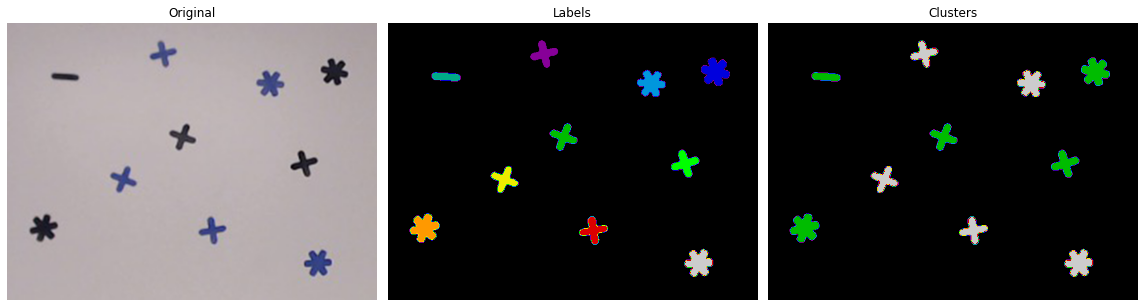

Nbr of black objects 5133 total area 5, nbr of blue objects 5156 total area 5


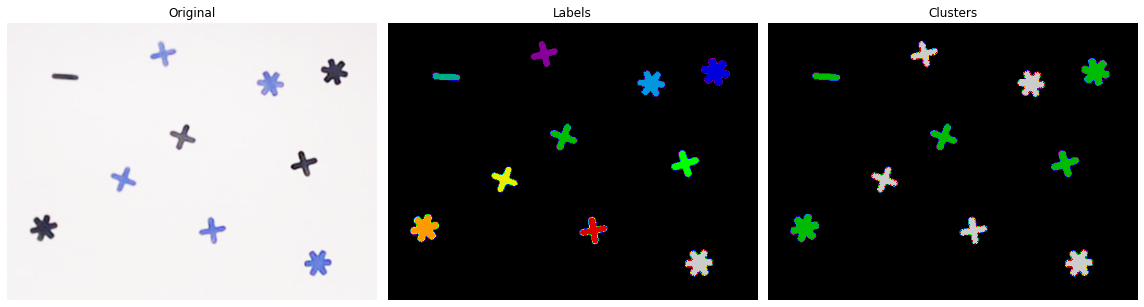

Nbr of black objects 5507 total area 5, nbr of blue objects 5616 total area 5


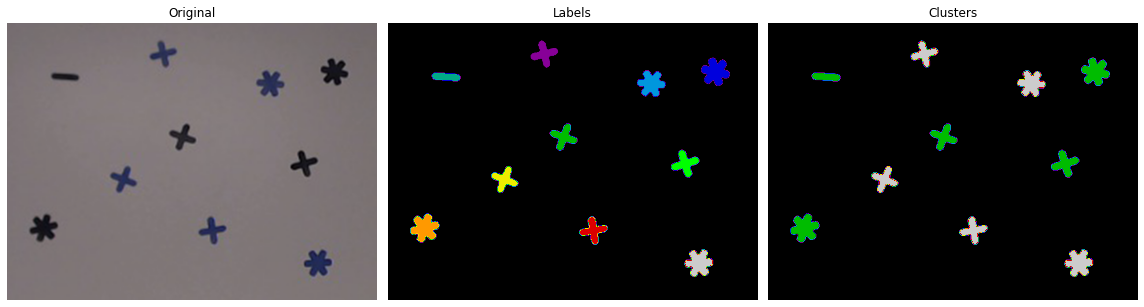

In [10]:



for im in images: #for each image
    # convert to grayscale
    im_gray = rgb2gray(im)
    # denoise image
    
    denoised = rank.median(img_as_ubyte(im_gray), disk(1))

    # define markers for wateshed
    # one small rectagle to define background
    # and markers where there is no background
    # background is defined as an interval around the mean color of the image
    markers = np.zeros_like(im_gray)
    thresh = np.average(im_gray)
    interval = 0.1
    markers[im_gray<thresh-interval] = 1
    markers[im_gray>thresh+interval] = 1
    rr, cc = rectangle((0,0), extent=(20,20), shape=markers.shape)
    markers[rr,cc] = 1    
    markers = label(markers)

    # sobel edges
    edge_sobel = filters.sobel(denoised)

    # perform the watershed
    labels = watershed(edge_sobel, markers) 
    
    # perform clustering 
    nb_obj = np.max(labels)-1
    X = np.zeros( (nb_obj, 1))
    for i in np.arange(nb_obj):  #Compute the mean color in each object, this feature is enough to cluster our objects ! 
        X[i] = np.mean(im[labels==i+2]) #Note : labels[i,j]=1 means background, so the first object is at labels[i,j]=2

    kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 600, n_init = 10, random_state =0)
    pred_y = kmeans.fit_predict(X)
    pred_y+=1 #to not have the 0 label (the prediction is therefore 1 or 2)

    cluster_labels = np.zeros(labels.shape)
    for i in np.arange(nb_obj):
        cluster_labels[labels==i+2] = pred_y[i]
    
    # display results
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8),sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(im)
    ax[0].set_title("Original")

    ax[1].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[1].set_title("Labels")

    ax[2].imshow(cluster_labels, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[2].set_title("Clusters")
    
    print("Nbr of black objects {} total area {}, nbr of blue objects {} total area {}".format(
          np.sum(cluster_labels==1),np.sum(pred_y==1),np.sum(cluster_labels==2),np.sum(pred_y==2)))
    
    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()